First, we’ll need to import several packages, including EventSegment, a functions from BrainIAK (a Brain Imaging Analysis Kit http://brainiak.org) that implemented this HMM variant (Kumar et al., 2020a, 2020b).

In [1]:
import warnings
import sys 
import os    

import numpy as np

import brainiak.eventseg.event

import scipy.io
from scipy.io import loadmat, savemat 
from scipy.io import savemat 
from scipy import stats
from sklearn.model_selection import KFold

from matplotlib import pyplot as plt
import matplotlib.patches as patches

import statsmodels.stats.multitest as sm
from statsmodels.nonparametric.kernel_regression import KernelReg

%autosave 5
%matplotlib inline

Autosaving every 5 seconds


We will use time series of BOLD activity from the brains of 25 participants as they imagine and listen to 6 different melodies, ranging in their duration from 20 to 51 samples in time (Regev et al., 2021). We will focus the analysis on the following regions of interest: Early AC R, Early AC L, Late AC R, Late AC L, Supra g L, Precun R, Precun L.

In [2]:
imagery_data = 'imagery_data' # will creat a folder with this name for future data

In [3]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")

if not os.path.exists(imagery_data):
    print('Make dir: ', imagery_data)
    os.makedirs(imagery_data)
else: 
    print('Data path exists')

Data path exists


# Trying out HMM

Following Williams et al. (2021), we’ll run HMMs with different numbers of hidden event states (k). We’ll start by exploring how timepoint-by-timepoint similarity matrix looks like in one region of the brain (precuneus) during imagery of a melody (‘Summer’), and overlap it with the event boundaries found by the HMM, assuming 10 event states for example.
In this similarity matrix, pattern correlations are computed for each timepoints in the melody. Blocks with high correlation around the diagonal indicate periods of time in which patterns stayed relatively constant.

In [194]:
def plot_tt_similarity_matrix(ax, data_matrix, bounds, n_TRs, title_text):
    #ax.figure(figsize=(10,8))
    im = ax.imshow(np.corrcoef(data_matrix.T), cmap='viridis')
    plt.colorbar(im)
        
    ax.set_title(title_text)
    ax.set_xlabel('TR')
    ax.set_ylabel('TR')
    
    # plot the boundaries 
    bounds_aug = np.concatenate(([0],bounds,[n_TRs]))
    for i in range(len(bounds_aug)-1):
        rect = patches.Rectangle(
            (bounds_aug[i],bounds_aug[i]),
            bounds_aug[i+1]-bounds_aug[i],
            bounds_aug[i+1]-bounds_aug[i],
            linewidth=2,edgecolor='w',facecolor='none'
        )
        ax.add_patch(rect)

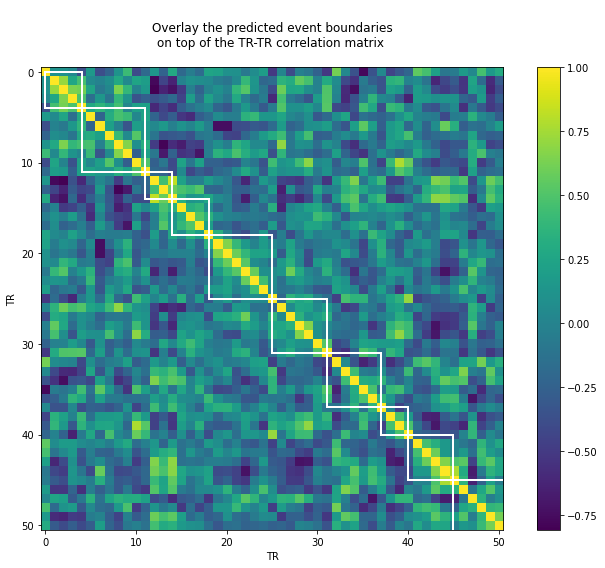

In [195]:
song = 'summer' # example song
task = '_ima_notap_'  # imagery task
roi = '354' # example regioin: Precun R

k_param = 10 # example number of event boundaries

# load data
filename = os.path.join(imagery_data, song + task + roi + '.mat')
mat = loadmat(filename)
BOLD = mat['D']

nVox, nTR, nSubj = BOLD.shape   

data = BOLD.mean(2) # average across voxels
# fit HMM
hmm = brainiak.eventseg.event.EventSegment(n_events=int(k_param), split_merge=True)
hmm.fit(data.T)

pred_seg = hmm.segments_[0]
bounds = np.where(np.diff(np.argmax(pred_seg, axis=1)))[0] # get event boundaries 

# plot similarity matrix and event boundaries
f, ax = plt.subplots(1,1, figsize = (10,8))
title_text = '''
Overlay the predicted event boundaries
on top of the TR-TR correlation matrix 
'''
plot_tt_similarity_matrix(ax, BOLD.mean(2), bounds, nTR, title_text)

f.tight_layout()

# Finding hidden event states

But how do we know what’s the preferred number of hidden event states in a region? 
We will vary the number of fitted event states (k’s) for a melody and test the performance of each model. To measure the model’s fit, we will use the averaged similarity between pairs of timepoint-specific multivoxel patterns falling within the same event, minus the average pattern similarity between patterns falling across events (Baldassano et al., 2017). This measure in called WvA score. Higher WvA scores indicate a better fit of the event boundaries to the data. 

For each k, we’ll use a nested 5-fold cross validation, where the model is trained on 20 participants and the WvA scores are calculated using the left out group of 5 participants. These scores are calculated in each region for each melody.
To test whether the models performed better than random, we will generate permuted versions of the identified boundaries, in which the number of event states is held constant, but their location is randomly shuffled. This should produce a null distribution of WvA scores with an average around zero, and its variance will reveal whether the WvA scores bassed on the events found by the model are significantly higher than chance. These results will be corrected for multiple comparisons of all possible k’s within each region using false discovery rate (FDR).

In [158]:
# Explore the performence of the model for each song during imagery or percpetion
song = 'summer' # 'summer', 'hospital', 'wind', 'carrying', 'pazus', 'reprise'
task = '_ima_notap_' # '_lis__' or '_ima_notap_'

n_split = 5 # number of cross validation folds
q = 0.05 # q for fdr
nPerm = 500 # n permutations foor null

rois = ['245', '45', '394', '196', '87', '354', '160'] # saved regions of interest 
roinames = ['Early AC R', 'Early AC L', 'Late AC R', 'Late AC L', 'Supra g L', 'Precun R', 'Precun L']# regions' labels
colors = ['#069AF3', '#069AF3', '#380282', '#380282', '#FF00FF', '#006400', '#006400']
linestyles = ['solid', 'dashed', 'solid', 'dashed', 'dashed', 'solid', 'dashed']

tr_dur = 1.5 # time in sample, sec

In [159]:
def wva_calc(events, local_mask, nPerm, k_param, nTR, k, counter):
    # Compute within vs across boundary correlations
    within_across = np.zeros(nPerm)
    for p in range(nPerm):
      #  print(str(p))
        same_event = events[:,np.newaxis] == events # creating a mask of within-events values
        within = cc[same_event*local_mask].mean() # by multiplying same_event*local_mask we get all within-event valuses inn the upper triangel of the corrmatrix
        across = cc[(~same_event)*local_mask].mean()
        within_across[p] = within - across # substracting the average between-event corr values from the average within-event corr values

        # after once doing the real events (above), now we permute them and claculate wVa again (in the following loop) - without keeping the same event length
        perm_events = np.random.permutation(range(nTR))[0:k_param[k]-1] # scramble TR index and pick k number of new event-boundaries
        events = np.zeros(nTR, dtype=np.int)
        events[perm_events]= 1
        events = np.cumsum(events)
        
    return within_across

In [160]:
def wva_stat(wva, nPerm, k_param, q):
    # non-parametric comparison of real WvA to scrambled ones
    min_p = 1 / (nPerm-1) # minimal p we can calc based on numper of permutations
    pvals = np.zeros(len(k_param)) # initialize with 0 - maybe better to initialize with a non 0/1 value?

    #print('Claculating pvals...')
    for k in range(len(k_param)): # going over each k of the song
        real = wva[k,0] # average across folds
        null = np.sort(wva[k,1:])

        bul = np.where(real <= null)[0] # find the index in null that is equal/excedes the resl value
        if len(bul)==0:
            pvals[k]=min_p
        else:
            l = bul[0] # find the smallest index in null that is equal/excedes the resl value
            pvals[k] = 1 - l/len(null) 
        #print('k ' + str(k_param[k]) + ':', pvals[k])

    # correct for multiple comparisons
    pas, pvals_cor = sm.fdrcorrection(pvals, alpha=q, method='indep', is_sorted=False)
    return pvals, pvals_cor, pas

roi  Early AC R  sig correct: k  [16 19 21 22]  p  [0.032 0.048 0.032 0.032]
roi  Early AC L  sig correct: k  [ 3 11 16 17 18 19 20 21 22 23 24 25 28 29 30 31 32 33]  p  [0.034 0.021 0.03  0.012 0.012 0.045 0.038 0.012 0.012 0.012 0.012 0.012
 0.045 0.048 0.03  0.029 0.03  0.012]
roi  Late AC R  sig correct: k  [ 7 12 16 18 24 25 26 27 28 29]  p  [0.019 0.048 0.048 0.048 0.048 0.019 0.048 0.019 0.019 0.019]
roi  Late AC L  sig correct: k  [13 14 16 17 19 21 22 26 27 29 31 34 35 36]  p  [0.038 0.041 0.027 0.038 0.027 0.024 0.041 0.024 0.024 0.04  0.04  0.024
 0.027 0.036]
roi  Supra g L  sig correct: k  [ 4  5 22 23 26 27]  p  [0.032 0.048 0.048 0.032 0.048 0.032]
roi  Precun R  sig correct: k  [ 5  6  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 37]  p  [0.007 0.039 0.039 0.011 0.007 0.011 0.007 0.007 0.007 0.011 0.007 0.007
 0.007 0.039 0.041 0.034 0.039 0.02  0.007 0.011 0.007 0.007 0.007 0.007
 0.007 0.037 0.039 0.039]
roi  Precun L  sig correct: k  [ 5

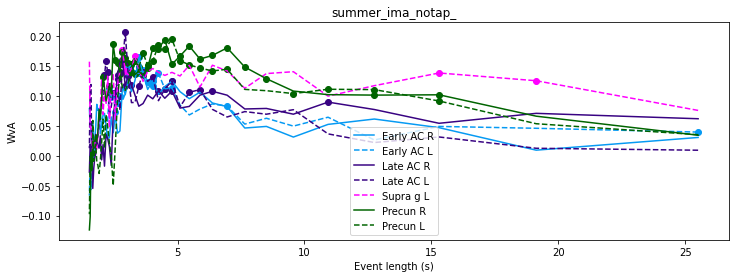

In [11]:
f, ax = plt.subplots(1,1, figsize = (12,4)) # initiate plot
for r in range(len(rois)):
    #print(rois[r])
    filename = os.path.join(imagery_data, song + task + rois[r] + '.mat')
    mat = loadmat(filename)
    BOLD = mat['D']

    nVox, nTR, nSubj = BOLD.shape   

    k_param = np.array(range(3,nTR))
    wVa_results = np.zeros((len(k_param), n_split, nPerm))

    for k in range(len(k_param)):
        #print('k ' + str(k_param[k]))
        kf = KFold(n_split)
        kf.get_n_splits(range(nSubj))

        counter = 0
        for train, test in kf.split(range(nSubj)):
            
            data_train = BOLD[:,:,train].mean(2) 
            # fit HMM
            hmm = brainiak.eventseg.event.EventSegment(n_events=int(k_param[k]), split_merge=True)
            hmm.fit(data_train.T)

            events = np.argmax(hmm.segments_[0],axis=1)
            max_event_length = stats.mode(events)[1][0]

            # Compute timepoint by timepoint correlation matrix of left out subjects
            cc = np.corrcoef(BOLD[:,:,test].mean(2).T) 
            _, event_lengths = np.unique(events, return_counts=True)

            # Create mask to only look at values up to max_event_length.
            # practicly, it creats a mask of almost the entire upper triangel of the matrix (including diagonal)
            local_mask = np.zeros(cc.shape, dtype=bool)
            for i in range(1,max_event_length):
                local_mask[np.diag(np.ones(cc.shape[0]-i, dtype=bool), i)] = True 

                wVa_results[k, counter, :] = wva_calc(events, local_mask, nPerm, k_param, nTR, k, counter)

            counter += 1 # tracing the CV folds
    ##
    wva = wVa_results[:,:,:].mean(1)
    
    # Because my goal was to find each area’s preferred event length, I converted the WvA results for each melody 
    # to be a function of the average event length (in seconds) rather than the number of events, and averaged these 
    # results across melodies.
    # Note that, since the excerpts are different lengths, a given number of events might correspond to different average 
    # event lengths for different melodies
    durs = np.array([nTR])*tr_dur
    durs = durs[:,np.newaxis] # flip row to col

    event_lengths = durs/k_param
    x = event_lengths.ravel()

    pvals, pvals_cor, pas = wva_stat(wva, nPerm, k_param, q)

    # save wva and p's per roi
    print('roi ', roinames[r], ' sig correct: k ', k_param[pas], ' p ', np.round(pvals_cor[pas],3))
    #np.savez(os.path.join(imagery_data, 'full_wva' + task + rois[r] + '_' + song + '_' + str(n_split) + 'fold_scramEv'), wVa_results=wVa_results, pvals=pvals, pvals_cor=pvals_cor, pas=pas)

    # plot wva acording to length    
    ax.plot(x, wva[:,0], color=colors[r], linestyle=linestyles[r])
    ax.scatter(x[pas], wva[pas,0], color=colors[r])
    ax.set_xlabel('Event length (s)')
    ax.set_ylabel('WvA')

ax.legend((roinames), loc='lower right')
ax.set_title(song + task)
plt.savefig('hmm_' + song + task)

# Finding prefered event lengths

There are different ways to operationalize the preferred event length of each region. Here we will consider two options: 
1) Compute the weighted average of all possible event lengths, with averaged WvA scores as the weights.
2) Use nonparametric kernel regression to fit a model for the WvA scores of all possible event lengths, and take the event length with the maximal predicted WvA score.

We will use both of these methods in each region of interest in each task (i.e., perception & imagery).

In [12]:
tasks = ['_lis__', '_ima_notap_']

songs = ['summer', 'hospital', 'wind', 'carrying', 'pazus', 'reprise']

rois = ['245', '45', '394', '196', '87', '354', '160']
roinames = ['Early AC R', 'Early AC L', 'Late AC R', 'Late AC L', 'Supra g L', 'Precun R', 'Precun L']

colors = ['#069AF3', '#069AF3', '#380282', '#380282', '#FF00FF', '#006400', '#006400']
linestyles = ['solid', 'dashed', 'solid', 'dashed', 'dashed', 'solid', 'dashed']

tr_dur = 1.5 
n_split = 5 # in name of saved files 

In [13]:
def wva_org(loadfile, tr_dur):
    # load and organize previously saved wva scores and event lengths
    npzfile = np.load(loadfile)
    npzfile.files
    wVa_results = npzfile['wVa_results']
    wva = wVa_results[:,:,:].mean(1)

    k, nPerm = wva.shape
    nTR = k+3
    k_param = np.array(range(3,nTR))

    # transform to event length
    durs = np.array([nTR])*tr_dur
    durs = durs[:,np.newaxis]

    event_lengths = durs/k_param
    
    return event_lengths.ravel(), wva[:,0]    

More about kernel regression: 
This is a nonparametric technique to estimate the conditional expectation of a random variable. The objective is to find a non-linear relation between a pair of random variables (here, WvA and event length). The function KernelReg specifically uses the Nadaraya-Wastonn Kernel regression. The bandwidth parameter controls the output’s variance/bias (small bw over-fits the data because of a narrower kernel which gives high wight to the y of x). We’ll use the same default criteria for estimating goodness of bw, which is least-squares cross-validation, averaged across all regions.

_lis__
Early AC R
weighted avg  4.84 weighted var  4.267
max length: 4.92 sec
Early AC L
weighted avg  5.109 weighted var  4.661
max length: 4.435 sec
Late AC R
weighted avg  4.314 weighted var  3.364
max length: 4.193 sec
Late AC L
weighted avg  4.219 weighted var  3.138
max length: 4.678 sec
Supra g L
weighted avg  4.871 weighted var  4.514
max length: 6.857 sec
Precun R
weighted avg  4.888 weighted var  4.314
max length: 5.404 sec
Precun L
weighted avg  5.048 weighted var  4.725
max length: 4.678 sec
_ima_notap_
Early AC R
weighted avg  5.828 weighted var  5.262
max length: 3.467 sec
Early AC L
weighted avg  4.488 weighted var  3.433
max length: 3.225 sec
Late AC R
weighted avg  5.777 weighted var  5.416
max length: 3.225 sec
Late AC L
weighted avg  4.5 weighted var  3.686
max length: 3.709 sec
Supra g L
weighted avg  4.875 weighted var  4.443
max length: 4.435 sec
Precun R
weighted avg  5.529 weighted var  5.146
max length: 6.13 sec
Precun L
weighted avg  5.339 weighted var  5.141


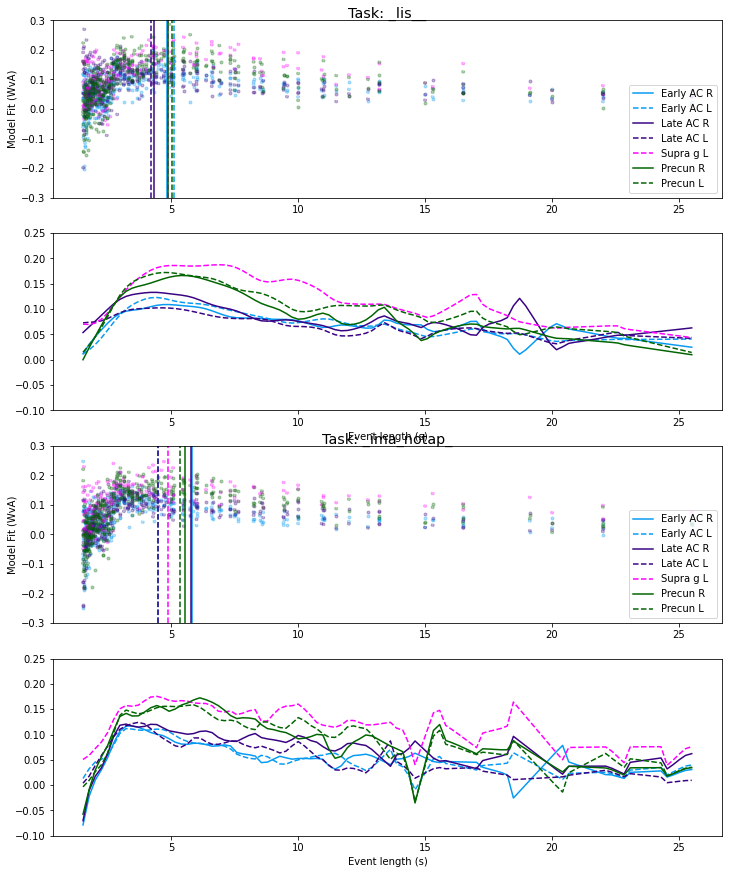

In [227]:
f, axs = plt.subplots(4,1, figsize = (12,15)) # initiate plot
count_t = 0
weight_avg = np.zeros((len(tasks), len(rois)))
weight_var = np.zeros((len(tasks), len(rois)))
weight_l = list([])

for t, task in enumerate(tasks):
    print(task)
    # optimize bandwidth (averaged across all rois):
    opt_bw = 0
    for r in range(len(rois)):
        concat_length = []
        concat_wva = []
        for s in range(len(songs)):
            loadfile = os.path.join(imagery_data, 'full_wva' + task + rois[r] + '_' + songs[s] + '_' + str(n_split) + 'fold_scramEv.npz')

            event_lengths, wva = wva_org(loadfile, tr_dur)

            concat_length = np.hstack((concat_length, event_lengths))
            concat_wva = np.hstack((concat_wva, wva))

        # find optimal bw for each roi by using the regression function
        unique_event_lengths = np.unique(concat_length)
        test_length = np.linspace(min(concat_length), max(concat_length), num=100)
        KR = KernelReg(concat_wva, concat_length, var_type='c')
        #print('bw:', str(KR.bw))
        opt_bw += KR.bw/len(rois) # final value will be the average of all rois

    # Now do nonparametric kernel regression for real, using the same bw, averaged across all regions:
    #print('opt bw:', opt_bw)
    max_wva_i_1 = np.zeros(len(rois))
    concat_length_weight = np.zeros((len(rois), len(concat_length)))
    for r in range(len(rois)):

        print(roinames[r])
        concat_length = []
        concat_wva = []
        
        for s in range(len(songs)):
            loadfile = os.path.join(imagery_data, 'full_wva' + task + rois[r] + '_' + songs[s] + '_' + str(n_split) + 'fold_scramEv.npz')
            event_lengths, wva = wva_org(loadfile, tr_dur)

            concat_length = np.hstack((concat_length, event_lengths))
            concat_wva = np.hstack((concat_wva, wva))
        
        # Claculate weighted average of all possible event lengths, with the WvA as the weights, within each region:
        n_sampl = len(concat_length) # same in each roi
        concat_length_weight[r,:] = ((concat_length*concat_wva) / np.sum(concat_wva))*n_sampl
        # transform negative weighted values (due to negative wva scores) to zero:
        concat_length_weight[r, concat_length_weight[r,:]<0] = 0
        weight_avg[t, r] = np.mean(concat_length_weight[r, :])
        weight_var[t, r] = np.std(concat_length_weight[r,:]) # will need for next analysis
        print('weighted avg ', np.round(weight_avg[t, r],3), 'weighted var ', np.round(weight_var[t, r],3))

        
        # Perform nonparametric kernel regression to predicting the wva in a range of event lengths:
        # [in the continuous case ('c') the kernel uses as the weights in the regression is the Gaussian kernel]
        test_length = np.linspace(min(concat_length), max(concat_length), num=100)
        KR = KernelReg(concat_wva, concat_length, var_type='c', bw = opt_bw)
        #print(np.round(KR.r_squared(),3)) # show model's r^2
        
        # Find the event length with the maximal predictted wva score:
        max_wva_i_1[r] = np.argmax(KR.fit(test_length)[0]) # maximum from the predicted values
        print('max length:', np.round(test_length[int(max_wva_i_1[r])],3), 'sec')
        reg_y_1 = KR.fit(test_length)[0]

        # plot data and weighted average (as a vertical line) for each region:
        axs[count_t].scatter(concat_length, concat_wva, color=colors[r], linestyle=linestyles[r], marker='.', alpha = 0.3)
        axs[count_t].axvline(x=weight_avg[t, r], color=colors[r], linestyle=linestyles[r])
        axs[count_t].set_ylim([-0.3, 0.3])
        # plot regression
        axs[count_t+1].plot(test_length, reg_y_1, color=colors[r], linestyle=linestyles[r])
        axs[count_t+1].set_ylim([-0.1, 0.25])

    axs[count_t].set_title('Task: ' + task, y=0.98 ,fontsize='x-large')
    axs[count_t].legend((roinames), loc='lower right', fontsize='medium')
    axs[count_t].set_ylabel('Model Fit (WvA)')
    axs[count_t+1].set_xlabel('Event length (s)')
    count_t += 2
    
    weight_l.append(concat_length_weight) # keep weighted values of 2 tasks for future comparison between tasks

# Comparing prefered event lengths across Perception and Imagery

Finally, we’ll compare the preferred event length (as estimated by the weighted average) of each region between perception and imagery of music. For this statistical test, we will use Welch’s t-test (2-tailed) across tasks, since the variances of the populations are unequal.

In [155]:
# take relevant data from previous analysis
dur_lis = weight_l[0].copy()
dur_ima = weight_l[1].copy()

weight_avg_ima = weight_avg[1,:].copy()
weight_var_ima = weight_var[1,:].copy()
weight_avg_lis = weight_avg[0,:].copy()
weight_var_lis = weight_var[0,:].copy()

In [226]:
alpha = 0.05 # for t-test

statistic = np.zeros(len(rois))
pvalue = np.zeros(len(rois))
for r in range(len(rois)):    
    statistic[r], pvalue[r] = stats.ttest_ind_from_stats(mean1=weight_avg_lis[r], std1=weight_var_lis[r], nobs1=n_sampl, mean2=weight_avg_ima[r], std2=weight_var_ima[r], nobs2=n_sampl, equal_var=False)

sig_rois = np.array(np.where(pvalue<=alpha)[0])
[roinames[i] for i in sig_rois]
# -> looks like only the right Early/Late AC are significant (but it can survive multiple comparison correction of only 4 regions)

['Early AC R', 'Late AC R']

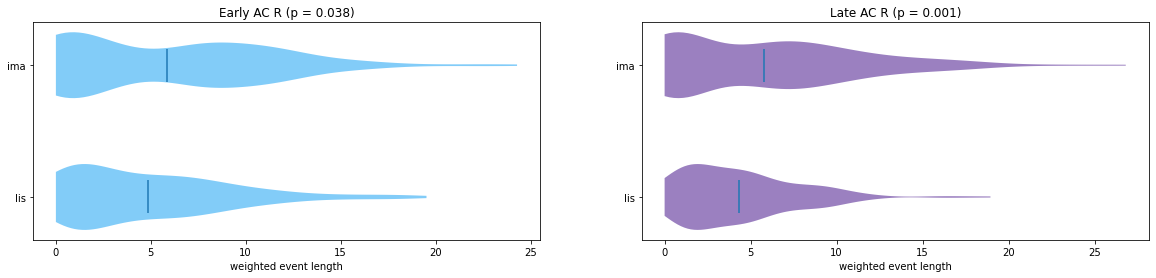

In [157]:
# plot the two significant regions
fig, axs = plt.subplots(1,2, figsize=(20,4))
for count, r in enumerate(sig_rois):
    parts = axs[count].violinplot((dur_lis[r,:], dur_ima[r,:]), showextrema=False, showmeans=True, vert=False)
    cond_label = ['lis', 'ima']
    axs[count].set_yticks([1, 2])
    axs[count].set_yticklabels(cond_label)
    axs[count].set_xlabel('weighted event length')
    axs[count].set_title(roinames[r] + ' (p = ' + str(np.round(pvalue[r],3)) + ')')
    for i in parts['bodies']:
        i.set_facecolor(colors[r])
        i.set_alpha(0.5)


# Conclusion:

We found that the prefered event timescales in the right auditory cortices (both early and late) are getting longer during imagery of complex musical content, comapred to its perception. Along the way, we also reproduced Williams et al.'s results, showing that high-order areas exhibit event-structured activity for longer periods than auditory cortex during perception of music.

__Refereces:__

Kumar M, Ellis C T, Lu Q, Zhang H, Capota M, Willke T L, Ramadge P J, Turk-Browne N B, Norman K A (2020a). BrainIAK tutorials: User-friendly learning materials for advanced fMRI analysis. PLOS Comp Biol, 16(1).

Kumar M, Anderson M J, Antony J W, … Norman K A (2020b). BrainIAK: The Brain Imaging Analysis Kit. OSF Preprints.

Williams J A, Margulis E H, Nastase S A, Chen J, Hasson U, Norman K A, Baldassano C (2021). High-order areas and auditory cortex both represent the high-level event structure of music. bioRxiv, https://doi.org/10.1101/2021.01.26.428291 

Regev M, Halpern A R, Owen A M, Patel A D, Zatorre R J (2021). Mapping specific mental content during musical imagery. Cereb Cortex, https://doi.org/10.1093/cercor/bhab036 
